In [ ]:
!pip install opencv-python

In [ ]:
from google.colab import files

# Upload image to Colab
uploaded = files.upload()

# Get the path to the uploaded image
image_path = list(uploaded.keys())[0]

Saving 22.jpg to 22.jpg


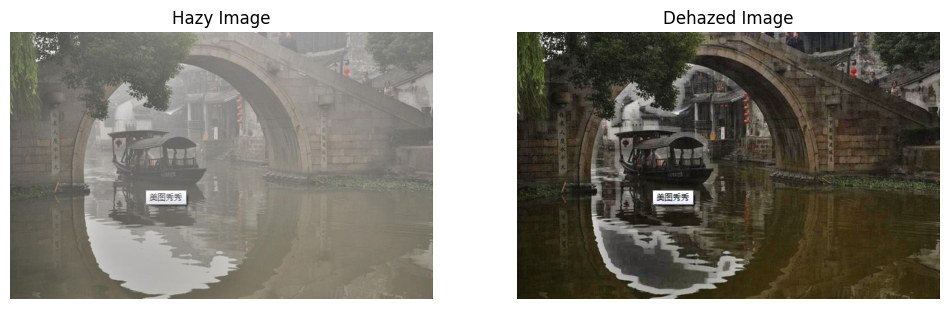

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dark_channel_prior(img, size=15):
    """Compute the dark channel prior of an image."""
    # Compute the minimum value over a window for each channel
    min_img = cv2.erode(img, np.ones((size, size), np.uint8))
    dark_channel = np.min(min_img, axis=2)
    return dark_channel

def estimate_airlight(img, dark_channel, percentile=0.001):
    """Estimate the airlight from the image based on the dark channel."""
    flat_dark = dark_channel.flatten()
    threshold = int(len(flat_dark) * percentile)
    brightest_pixels = np.argpartition(-flat_dark, threshold)[:threshold]
    airlight = np.max(img.reshape(-1, 3)[brightest_pixels], axis=0)
    return airlight

def dehaze(img, airlight, omega=0.95, t0=0.1):
    """Perform the dehazing operation on the image."""
    img = img.astype(np.float64)  # Convert to float for calculations
    transmission = 1 - omega * dark_channel_prior(img / airlight)
    transmission = np.maximum(transmission, t0)  # Avoid division by zero
    dehazed = np.zeros_like(img)
    for i in range(3):  # Dehaze each channel separately
        dehazed[:, :, i] = (img[:, :, i] - airlight[i]) / transmission + airlight[i]
    return np.clip(dehazed, 0, 255).astype(np.uint8)

# Load the hazy image
hazy_img = cv2.imread(image_path)

# Compute dark channel prior
dark_channel = dark_channel_prior(hazy_img)

# Estimate airlight
airlight = estimate_airlight(hazy_img, dark_channel)

# Perform dehazing
dehazed_img = dehaze(hazy_img, airlight)

# Display original and dehazed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(hazy_img, cv2.COLOR_BGR2RGB))
plt.title('Hazy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(dehazed_img, cv2.COLOR_BGR2RGB))
plt.title('Dehazed Image')
plt.axis('off')

plt.show()
